# Psi method 

## Overview of the method

The Psi method is a Bayesian adaptive alogrithm to estimate the threshold and slope of a psychometric function. Most of the concepts in this notebook is taken from Kontesevich and Tyler 1997 from the Journal Vision Research. 

The threshold of the psychometric function, denoted by $\alpha$, is the inflection point of the function, or the point at wich the response is 50/50 (in this specific case). It represents the bias in the estimates. The slope, denoted by $\beta$, reflects the uncertainty in the estimate. 

This specific notebook and simulations were designed with a specific task in mind: A 2-Alaternate forced choice (AFC) task with the goal of estimating the sense of lower limb symmetry. Individuals stand on a split-belt treadmill with visual and auditory feedback occluded. The belt slowly moves their test limb from a randomly chosen distractor location to the stimulus location. Participants are then asked to respond if their left or right limb is more anterior. Thus, the threshold is the estimate of the individuals sense of limb symmetry. The algorithm in this notebook is written in reference to this task where the left limb is the test stimulus and is being passively moved by the treadmill and right limb is stationary.

Below is a brief introduciton to the broad strokes of the Psi algorithm followed by more detailed descriptions and code blocs which describe the method and run checks to ensure the code is working properly. Finally, I simulate the full method towards the end. 

***
***

The Psi method is an adaptive method in that the next stimulus is selected based on the previous response(s). This is in constrast to the method of constant stimuli which provides the same stimuli a pre-set number of times. Adaptive methods need to address three main considerations:
1. Estimate of psychometric parameters ($\alpha$ and $\beta$ in our case)
2. The termination rule
3. Placement of the next trial

***

1. **Estimate the psychometric parameters ($\alpha$ and $\beta$)**

    The most efficient way to obtain these estimates is to use Bayesian estimation. First, we define the 2-d prior by making an initial guess for each of the parameters:
    
    $p(\alpha, \beta)$
    
    Then, after the response, $r$, we calculate the probability of all prior responses, given each set of parameter values:
    
    $p(r | \alpha, \beta)$
    
    Multiplying these distributions together yields the posterior distribution of all possible parameter values:
    
    $p(\alpha, \beta | r)$

    The mean of this distribution is the best estimate of the parameters because it minimizes the variance of the threshold and is more stable than using the maximum a posteri. 

    The posterior then becomes the prior for the next trial, and the process repeats until the test is terminated. 
    
***

2. **Termination rule**

    There are several different options, for simplicity and task considerations (we want each individual to take a similar amount of time), we plan on stopping after a certain number of trials.
    
***

3. **Placement of the next trial**

    This is where the psi algorithm really does its work. To estimate threshold the most optimal location for the next stimulus is at the current threshold estimate, for the slope, it is slightly above and below the stimulus (in general). But, what specific stimulus should we choose? 
    
    Before each trial, the Psi algorithm simulates over every possible stimulus location for the next trial, $x$, calculating a posterior distribution for both possible responses at each $x$. Then, it calculates the Information Entropy ($H$) for each stimulus location ($H(x)$). The next stimulus is the one that minimizes the information entropy: $\underset{x}{argmin} (H(x))$
    
    Information entropy is the amount of uncertainty in the distribution. Moving from an uncertain distribution to one with more certinaty increases the amount of infomration we can gain from one trial to the next. For example, the weather forcast in Newark, DE 7 days from now is 61 and cloudy. There is uncertainty in this prediction, but when that day comes, there will be no uncertainty. Therefore, we have gained information about the weather. In the contex of choosing the next stimulus, the one that has the smallest entropy has the smallest amount of uncertainty in the distribution. Therefore, it is the one that will provide us with the most information on the next trial. 
    
    Information entroy is calculated as the probability times the log probability:
    
    $H = - \sum{p * log(p)}$

***
***

In [35]:
#Import python notebooks
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import expon
from scipy.stats import norm
from numpy.random import random
plt.rcParams['text.usetex'] = False
plt.rcParams.update({'font.size': 18})

## Explain each component and test

### Look up table

First, we need to define a look-up table to speed up the method. Specifically, we will use this in the entropy calculation. This lookup table contains conditional probabilities of both possible responses given the parameter values and the stimulus location:

$p(r| \alpha,\beta,x)$

This probability is defined by:

$p(r=left | \alpha,\beta,x) = \Psi_{\alpha,\beta}(x)$

$p(r=right | \alpha,\beta,x) = 1-\Psi_{\alpha,\beta}(x)$

In [2]:
def Psi_lookT(X,a_range,b_range):
    """
    This function creates two lookup tables required for the psi algorithm to run more efficiently
    It is a table of probabilities for both responses (left and right in this case) given all possible
    alpha and beta values and all possible stimulus locations:
    p(r='left'|alpha,beta,X)
    p(r='right'|alpha,beta,X)
    """
    #Set these nuisance parameters to nonzero values
    gam = 0.02
    lam = 0.02
    
    #Preallocate the lookup tables
    p_left_look = np.empty([len(b_range),len(a_range),(len(X))])
    p_right_look = np.empty([len(b_range),len(a_range),(len(X))])
    
    #Loop through all possible stimulus, alpha and beta values
    for x_i, x in enumerate(X):
        for a_i, a in enumerate(a_range):
            for b_i, b in enumerate(b_range):
                psi = gam + (1 - lam - gam) * norm.cdf(x,a,b)
                p_left_look[a_i,b_i,x_i] = psi
                p_right_look[a_i,b_i,x_i] = 1-psi

    return p_left_look, p_right_look

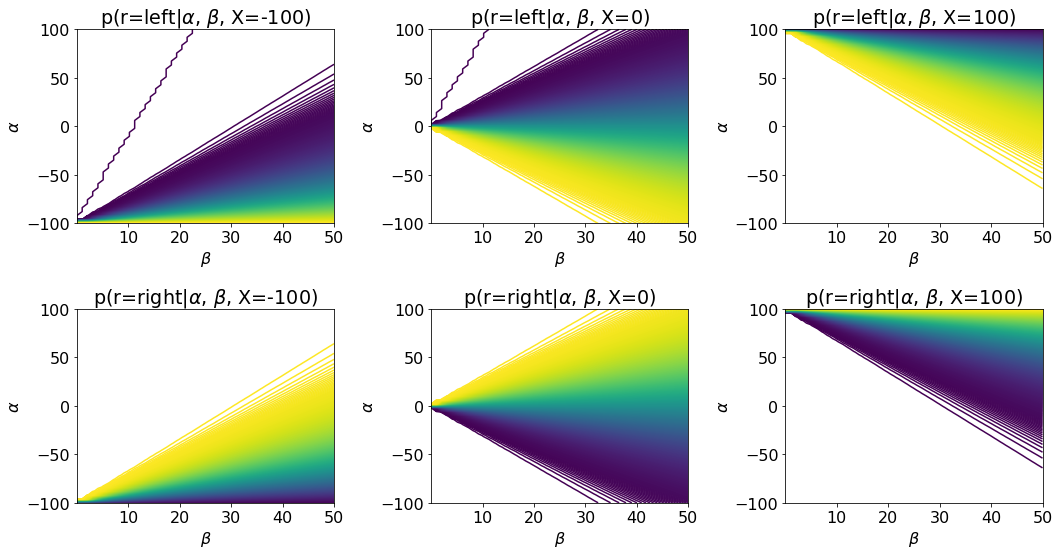

In [3]:
#Test to make sure this is working
#Set the ranges
X = np.arange(-100,110,10)
a_range = np.linspace(-100,100)
b_range = np.linspace(0.001,50)

#Run the function
p_left_look, p_right_look = Psi_lookT(X,a_range,b_range)

#Plot
fig, ax = plt.subplots(2, 3,figsize=(15,8),tight_layout=True)
ax[0,0].contour(b_range,a_range,p_left_look[:,:,0],1000)
ax[0,0].set(title=r'p(r=left|$\alpha$, $\beta$, X=-100)',xlabel=r'$\beta$',ylabel=r'$\alpha$')
ax[0,1].contour(b_range,a_range,p_left_look[:,:,10],1000)
ax[0,1].set(title=r'p(r=left|$\alpha$, $\beta$, X=0)',xlabel=r'$\beta$',ylabel=r'$\alpha$')
ax[0,2].contour(b_range,a_range,p_left_look[:,:,-1],1000)
ax[0,2].set(title=r'p(r=left|$\alpha$, $\beta$, X=100)',xlabel=r'$\beta$',ylabel=r'$\alpha$')

ax[1,0].contour(b_range,a_range,p_right_look[:,:,0],1000)
ax[1,0].set(title=r'p(r=right|$\alpha$, $\beta$, X=-100)',xlabel=r'$\beta$',ylabel=r'$\alpha$')
ax[1,1].contour(b_range,a_range,p_right_look[:,:,10],1000)
ax[1,1].set(title=r'p(r=right|$\alpha$, $\beta$, X=0)',xlabel=r'$\beta$',ylabel=r'$\alpha$')
ax[1,2].contour(b_range,a_range,p_right_look[:,:,-1],1000)
ax[1,2].set(title=r'p(r=right|$\alpha$, $\beta$, X=100)',xlabel=r'$\beta$',ylabel=r'$\alpha$')
plt.show()

**Explination:**

The lookup tables are essentially simulations of each response option given all possible world states (alpha, beta, X-stim values). Specifically they are 3d tables of probabilities for each response (left and right) given all possible alphas, betas, and stimulus positions. Plotted above are examples of different probability distributions for specific stimulus positions. 

For example, in the top middle plot we have the probability of the response being "left" given all possible alpha and beta values at the stimulus position X=0. If a person responds 'left' at the stimulus value X=0, it is more likely that their threshold (alpha) is below 0 (imagine the psychometric function with a negative threshold). The opposite is true fo r='right' (bottom middle). Note this does not give us much information about the beta values because we are dealing with just the single trial. 

Now lets take the extreme example of a stimulus at X=-100 (first column) and the response is left (top left). First of all, this is a very unlikley response and indiates the most likely threshold is less than -100. It is much more likely for the response to be "right" at this extreme stimulus, so it does not give us much information about the threshold. 

Similar logic can be used for the opposite extreme case of X=100 (3rd column). 

### Entropy function

Now we use infomration entropy to determine the most informative stimulus for the next trial. To acomplish this, we simulate the next trial at each possible stimulus location, taking into account the probabilities of both responses and the prior information. We calculate the entropy of the posterior distribution for each stimulus value. Then choose the stimulus with the smallest information entropy. Lets go through this step by step:

1. Calculate the probability of getting the response r='left' and r='right' after presenting stimulus $X_i$:

    $ p_i(r=left | X_i) = \underset{\alpha, \beta}{\sum} p_i(r=left | \alpha, \beta, X_i) p(\alpha, \beta)$

    and

    $ p_i(r=right | X_i) = \underset{\alpha, \beta}{\sum} p_i(r=right | \alpha, \beta, X_i) p(\alpha, \beta)$
    
    Note that $p_i(r=left | \alpha, \beta, X_i)$ is the lookup table we just created above! We just need to index the current stimulus value that we want, then combine that probability distribution with the prior we set. We are summing over all possible $\alpha$ and $\beta$ values. These probabilities are scalars and represent the probability of a left and a right response over all possible world states.


2. Next, we use bayesian estimation to calculate the posterior probability for of $\alpha$ and $\beta$ values given the current stimulus location and the response:

    $ p_i(\alpha, \beta | X_i, r=left) = \frac{\displaystyle p_i(r=left | \alpha, \beta, X_i) p(\alpha, \beta)}{\displaystyle p_i(r=left | X_i)}$
    
    and 
    
    $ p_i(\alpha, \beta | X_i, r=right) = \frac{\displaystyle p_i(r=right | \alpha, \beta, X_i) p(\alpha, \beta)}{\displaystyle p_i(r=right | X_i)}$
        
    This is essentially what we did in step 1 without the marginialization and we are normalizing so each distribution sums to 1. Now we have a posterior which represents the probabilities of $\alpha$ and $\beta$ values given each response at the current stimulus location. 
    
    
3. Now we calculate entropy. Generally, this is the equation: $H = - \sum{p * log(p)}$. Here we need to calculate entropy for both of our posterior distributions:

    $ H_i(X_i,r=left) = -\underset{\alpha, \beta}{\sum} post_{L} log_2(post_{L})$    
    
    and
    
    $ H_i(X_i,r=right) = -\underset{\alpha, \beta}{\sum} post_{R} log_2(post_{R})$
    
    Note that I shortened the probability notation from step 2 to $post_{L}$ and $post_{R}$ for simplicity. This gives us the entropy for both the left and the right posterior distribution that we calculated. 
    
    
4. But, we need a single expected entropy value for the current stimulus location, $X_i$. The expected entropy value for $X_i$ is therefore a weighted sum of each individual entropy calculation. They are weighted by the probability of each response:

    $EH_i = H_i(X_i,r=left)p_i(r=left | X_i) + H_i(X_i,r=right)p_i(r=right | X_i)$
    
After performing the same calculations for each stimulus position, we find the minimum expected entropy value. The corresponding stimulus location is the one which will provide us with the most information for the subsequent trial. 

$\underset{x}{argmin} (EH_i)$

Lets dive a little deeper into the function by looking at the posteriors and subsequent entropy calculations for a few stimulus locations. 

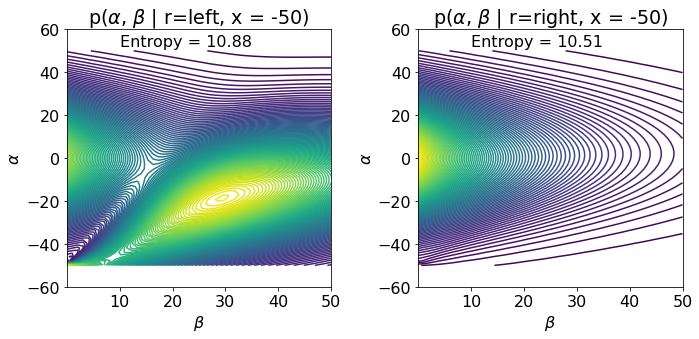

p_left = 0.05; p_right = 0.95
Total Entroy at X=-50: 10.53


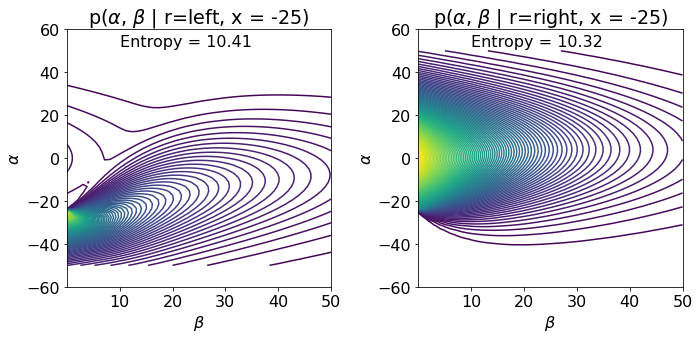

p_left = 0.18; p_right = 0.82
Total Entroy at X=-25: 10.33


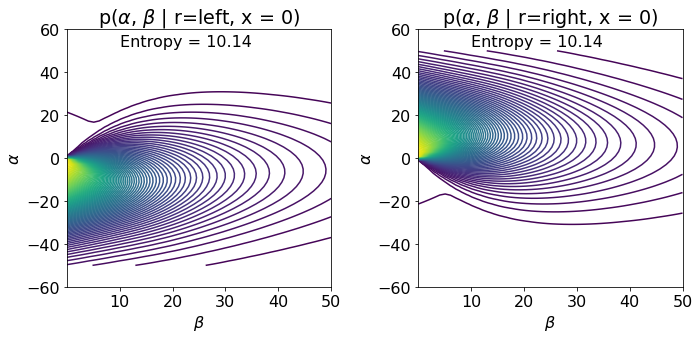

p_left = 0.5; p_right = 0.5
Total Entroy at X=0: 10.14


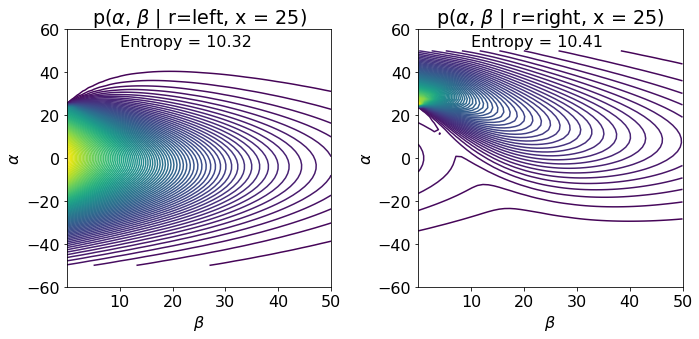

p_left = 0.82; p_right = 0.18
Total Entroy at X=25: 10.33


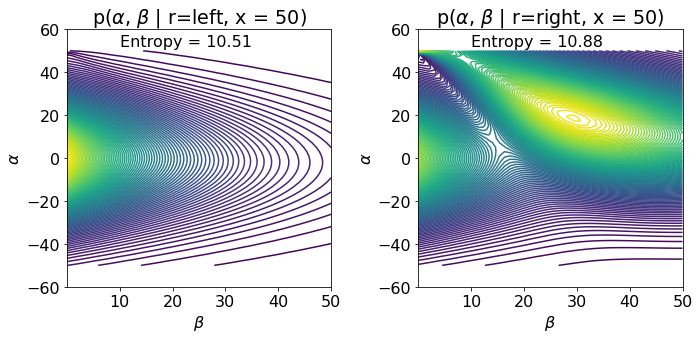

p_left = 0.95; p_right = 0.05
Total Entroy at X=50: 10.53


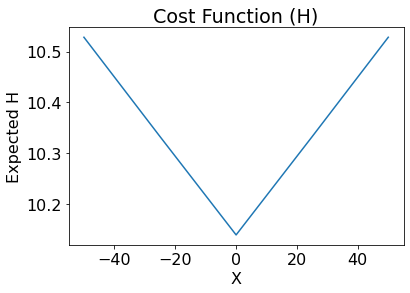

In [6]:
#Ranges
X = np.arange(-50,75,25)
a_range = np.linspace(-50,50)
b_range = np.linspace(0.001,50)
p_left_look, p_right_look = Psi_lookT(X,a_range,b_range)

#Set the priors
p_alpha = norm.pdf(a_range,0,20)
p_beta = expon.pdf(b_range,0,20)
p_alpha = np.reshape(p_alpha,(len(p_alpha),1))
p_beta = np.reshape(p_beta,(len(p_beta),1))
#Create the 2d prior and make sure it sums to 1
Prior = p_alpha @ p_beta.T
Prior = Prior/np.nansum(np.nansum(Prior))

#Entropy function -----------------------------------
#Simulate through each possible stim value, X
EH = []
for i, x in enumerate(X):
    
    #Calculate the probability of getting a response, r, after presenting test x at the next trial (across all possible parameter values)
    p_left = np.nansum(np.nansum(np.multiply(p_left_look[:,:,i],Prior)))
    p_right = np.nansum(np.nansum(np.multiply(p_right_look[:,:,i],Prior)))
        
    #Calculate the posterior for each response 
    Post_left = np.multiply(Prior,p_left_look[:,:,i])
    Post_left = np.divide(Post_left, np.nansum(np.nansum(Post_left)))
    Post_right = np.multiply(Prior,p_right_look[:,:,i])
    Post_right = np.divide(Post_right, np.nansum(np.nansum(Post_right)))
    
    #Estimate the entropy of the posterior distribution for each response
    H_left = -np.nansum(np.nansum(np.multiply(Post_left, np.log2(Post_left))))
    H_right = -np.nansum(np.nansum(np.multiply(Post_right, np.log2(Post_right))))

    #Combine the entropy calculations, weighted by their probabilities
    Total_H = (H_left*p_left) + (H_right*p_right)
    EH.append(Total_H)

    #Plot
    fig, ax = plt.subplots(1, 2, figsize=(10,5),tight_layout=True)
    ax[0].contour(b_range,a_range,Post_left,100)
    ax[0].text(10,52, 'Entropy = '+str(round(H_left,2)))
    ax[0].set(title=r'p($\alpha$, $\beta$ | r=left, x = '+str(x)+')' ,xlabel=r'$\beta$',ylabel=r'$\alpha$',ylim=(-60, 60))
    ax[1].contour(b_range,a_range,Post_right,100)
    ax[1].set(title=r'p($\alpha$, $\beta$ | r=right, x = '+str(x)+')' ,xlabel=r'$\beta$',ylabel=r'$\alpha$',ylim=(-60, 60))
    ax[1].text(10,52, 'Entropy = '+str(round(H_right,2)))
    plt.show()    
    
    print('p_left = ' + str(round(p_left,2)) + '; p_right = ' +str(round(p_right,2)) )
    print('Total Entroy at X=' + str(x) + ': ' + str(round(Total_H,2)))
    
EH = np.array(EH)
fig, ax = plt.subplots(1)
ax.plot(X,EH)
ax.set(xlabel='X',ylabel='Expected H',title='Cost Function (H)')
plt.show()

**Explination:**

Ok what are we looking at here? First, the purpose of this entropy calculation is to simulate one trial ahead to determine which stimulus value will provide the most information. Think of this type of entropy (information entropy) as the amount of uncertainty in a distribution. A wider distribution will have greater information entropy, while a narrower distribution will have less entropy. We are looking for the stimulus position with the highest certainty (lowest entropy) which will maximize the amount of information we can gain from that stimulus position. 

Lets take the first *simulated* stimulus position, X=-50 in the first row of plots. We are looking at posterior probability distributions for our possible alpha and beta values. This posterior distribution is the combination of the prior probability distribution, $p(\alpha,\beta)$, and the probability of the responses given each parameter and the stimulus value, $p(r=left | \alpha, \beta, X=-50)$ and $p(r=right | \alpha, \beta, X=-50)$. If the stimulus is set at -50 for the next trial (the left foot is well behind the right) but the response is still left (left plot), the resulting distribution suggests that the threshold (alpha) is most likely around -50 or lower or less than that but very uncertain. Note that there is a small blip of higher probability around 0 which is from the prior. This resulting distribution is relatively more uncertain than the distribution if the response was right (not the higher entropy). The total entropy at X=-50 (printed below the plot), is the weighted combination of the entropy of both posterior probability distributions. In other words, the left and right posterior probability distributions are weighted by the probability of each response given all alpha and beta values at the current stimulus X=-50, denoted by p_left and p_right. Hence, the total entropy for this stimulus value (10.53) is closer to the right distribuiton (10.51) which makes sense because the overall probability of a right response at x=-50 is much higher. 

The subsequent rows do the same thing for different stimulus positions. Notice that the stimulus position that minimizes entropy is 0 for the first trial. This is because the prior we set is centered on 0 for the threshold value (last plot).

***

So how can we 'kick the tires' on the entropy calculation to make sure it is doing what we want it to? Well, lets say that both responses are equally probable at all possible alpha and beta values (unrealistic but works for our purpose). In other words, the lookup tables for the left and the right are all 0.5. This prevents the simulated responses from playing a role in the entropy calculation. So now the only input to the system is the prior. We can plug in different priors, for each loop in the entropy calculation, changing the one with the lowest sigma each time. The prior with the lowest SD should be the one selected for the minimum entropy. Lets see if this is the case:

C:\Users\Jonathan\AppData\Local\Temp/ipykernel_19380/1096319194.py:56: RuntimeWarning: divide by zero encountered in log2
  H_left = -np.nansum(np.nansum(np.multiply(Post_left, np.log2(Post_left))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_19380/1096319194.py:56: RuntimeWarning: invalid value encountered in multiply
  H_left = -np.nansum(np.nansum(np.multiply(Post_left, np.log2(Post_left))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_19380/1096319194.py:57: RuntimeWarning: divide by zero encountered in log2
  H_right = -np.nansum(np.nansum(np.multiply(Post_right, np.log2(Post_right))))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_19380/1096319194.py:57: RuntimeWarning: invalid value encountered in multiply
  H_right = -np.nansum(np.nansum(np.multiply(Post_right, np.log2(Post_right))))


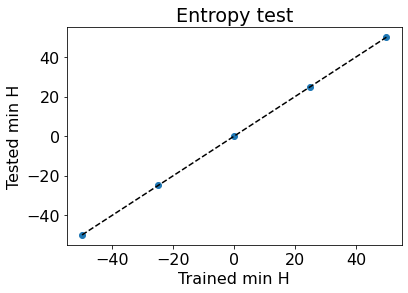

In [29]:
#Ranges
X = np.arange(-50,75,25)
a_range = np.linspace(-50,50)
b_range = np.linspace(0.001,50)

minH_train = X

#Matrix of sigmas for each prior
#arranged so that each stimulus location will have its turn having the lowest sigma
Prior_sigs = abs((np.eye(len(X))+1) - 3)

#Set up a new lookup tables with 50/50 everywhere
p_left_look = np.empty([len(b_range),len(a_range),(len(X))])
p_right_look = np.empty([len(b_range),len(a_range),(len(X))])
#Loop through all possible stimuli, alpha, and beta values
for x_i, x in enumerate(X):
    for a_i, a in enumerate(a_range):
        for b_i, b in enumerate(b_range):
            psi = norm.cdf(x,a,0.1)
            p_left_look[a_i,b_i,x_i] = 0.5
            p_right_look[a_i,b_i,x_i] = 0.5

minH_test = []
for p in range((len(Prior_sigs))):

    #Index the current array of sigmas from the matrix
    sigma_array = Prior_sigs[p,:]

    #Entropy function -----------------------------------
    #Simulate through each possible stim value, X
    EH = []
    for i, x in enumerate(X):

        #Set the priors
        p_alpha = norm.pdf(a_range,x,sigma_array[i]) 
        #note that the mean here is the current x value, 
        #the sigma array is set up so that the curret x will have the lowest sigma 
        
        p_alpha = np.reshape(p_alpha,(len(p_alpha),1))
        p_beta = expon.pdf(b_range,0,20)
        p_beta = np.reshape(p_beta,(len(p_beta),1))
        Prior = p_alpha @ p_beta.T
        Prior = Prior/np.nansum(np.nansum(Prior))

        #Calculate the probability of getting a response, r, after presenting test x at the next trial (across all possible parameter values)
        p_left = np.nansum(np.nansum(np.multiply(p_left_look[:,:,i],Prior)))
        p_right = np.nansum(np.nansum(np.multiply(p_right_look[:,:,i],Prior)))

        #Calculate the posterior for each response 
        Post_left = np.multiply(Prior,p_left_look[:,:,i])
        Post_left = np.divide(Post_left, np.nansum(np.nansum(Post_left)))
        Post_right = np.multiply(Prior,p_right_look[:,:,i])
        Post_right = np.divide(Post_right, np.nansum(np.nansum(Post_right)))

        #Estimate the entropy of the posterior distribution for each response
        H_left = -np.nansum(np.nansum(np.multiply(Post_left, np.log2(Post_left))))
        H_right = -np.nansum(np.nansum(np.multiply(Post_right, np.log2(Post_right))))

        #Combine the entropy calculations, weighted by their probabilities
        Total_H = (H_left*p_left) + (H_right*p_right)
        EH = np.append(EH,Total_H)

    minH_test = np.append(minH_test, X[np.argmin(EH)])

fig, ax = plt.subplots(1)
ax.plot(minH_train,minH_test,'o')
ax.plot(X,X,'k--')
ax.set(ylabel='Tested min H', xlabel='Trained min H',title='Entropy test')
plt.show()

As expected, the prior with the lowest uncertainty (i.e., minimum entropy), is the one that is chosen for the next stimulus location. 

### Psi simulation function

At this point in the algorithm, we have selected the best possible stimulus location for the subsequent trial using information entropy. Now we will use Bayesian estimation to estimate the actual parameters. This process is similar to other Bayesian adaptive algorithms that estimate psychometric parameter values. Here we are interested in estimating both the psychometric threshold ($\alpha$) and the uncertainty ($\beta$). Here are the steps:

1. Set the prior. This is a 2d prior that serves as our initial guess.

    $p(\alpha, \beta)$
    

2. Provide the stimulus at the location we calculated in the entropy section and record the participants response. 


3. Calculate the probability of obtaining the response given all possible parameter values (i.e., the likelihood) which is given by:

    $p(r | \alpha, \beta) = \prod \psi^k * (1-\psi)^{N - k} $
    
    * r = response (left or right)
    * k = number of times a left response is recorded
    * N = total number of trials at that stimulus value
    * $\psi = \gamma + (1-\gamma - \lambda) normcdf(X,\alpha,\beta) $
    
    $\gamma$ and $\lambda$ represent the guess and lapse rates, respectively. 
    

4. Combine the prior and the likelihood:

    $p(\alpha, \beta | r) = p(r | \alpha, \beta) p(\alpha, \beta) $
    
    
5. The posterior becomes the prior for the subsequent trial


6. The mean of the posterior distribution on the last trial is our final estimate of the parameters
        
To ensure the bayesian estimation is working properly, this next block of code simulates a single participate with Ntrials at all the possible stimulus positions. Simulated parameters and randomzied and the Bayesian estimation algorithm is used to recover these parameters. 

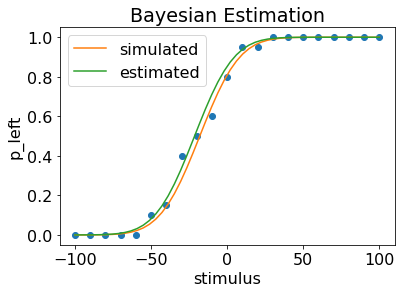

Alpha:
Simulated =  -18.01 ; estimated =  -21.43

Beta:
Simulated =  20.55 ; estimated =  20.41


In [26]:
#Test to see the fits - single simulation 
Ntrials = 20 #trials per stimulus level

# Set simulated parameter values
alpha_sim = norm.rvs(0,20)
beta_sim = expon.rvs(20)

#Set the priors
p_alpha = norm.pdf(a_range,0,20)
p_alpha = np.reshape(p_alpha,(len(p_alpha),1))
p_beta = expon.pdf(b_range,0,20)
p_beta = np.reshape(p_beta,(len(p_beta),1))
Prior = p_alpha @ p_beta.T
Prior = Prior/np.nansum(np.nansum(Prior))
    
#Stimuli ranges
X = np.arange(-100,110,10)
a_range = np.linspace(-50,50)
b_range = np.linspace(0.001,50)

#Randomize the stimuli
All_stims = []
for n in range(Ntrials):
    All_stims = np.append(All_stims,np.random.permutation(X))

#Loop through all trials
stims = []
responses = []
alpha_EV = []
beta_EV = []
for i in range(len(All_stims)):

    stims = np.append(stims,All_stims[i])
    
    #Simulate participant
    p_left = norm.cdf(All_stims[i],alpha_sim,beta_sim)
    responses = np.append(responses, p_left > np.random.rand())
    
    #Account for repeated stimuli 
    Unique_stims, stim_idx = np.unique(stims, return_index=True)
    Unique_stims = stims[np.sort(stim_idx)]
    Nstims = []
    Kleft = []
    for u in Unique_stims:
        stim_idx = np.argwhere(u==stims)[:,0]
        Nstims = np.append(Nstims,len(stim_idx))
        Kleft = np.append(Kleft, np.sum(responses[stim_idx]))
        
    #Calcualte the likelihood for the response given the current parameters
    Likelihood = np.empty((len(a_range),len(b_range)))
    for a_idx, a in enumerate(a_range):
        for b_idx, b in enumerate(b_range):
            psi = norm.cdf(Unique_stims,a,b)
            Likelihood[a_idx,b_idx] = np.prod((psi**Kleft) * ((1-psi)**(Nstims-Kleft)))

    #Calculate the posterior
    Posterior = Likelihood*Prior
    Posterior = Posterior/np.nansum(np.nansum(Posterior))

    #Marginalize the posterior
    alpha_post = np.nansum(Posterior,axis=1)
    beta_post = np.nansum(Posterior,axis=0)

    #Calculate the expected value of each
    alpha_EV = np.append(alpha_EV,np.nansum(a_range*alpha_post))
    beta_EV = np.append(beta_EV,np.nansum(b_range*beta_post))

    #The posterior becomes the prior for the next trial
    Prior = Posterior  
    
#Calculate the estimates
alpha_est = alpha_EV[-1]
beta_est = beta_EV[-1]
xaxis = np.linspace(-100,100)
est_psi = norm.cdf(xaxis,alpha_est,beta_est)
sim_psi = norm.cdf(xaxis,alpha_sim,beta_sim)

#Plot
fig, ax = plt.subplots(1)
ax.plot(Unique_stims,(Kleft/Nstims),'o')
ax.plot(xaxis,sim_psi,label='simulated')
ax.plot(xaxis,est_psi,label='estimated')
ax.set(xlabel='stimulus',ylabel='p_left',title='Bayesian Estimation')
ax.legend()
plt.show()

print('Alpha:')
print('Simulated = ',round(alpha_sim,2), '; estimated = ',round(alpha_est,2))
print('')
print('Beta:')
print('Simulated = ',round(beta_sim,2), '; estimated = ',round(beta_est,2))

This looks pretty good given enough trials (the more the better). Now I will run the same thing over more participants to make sure. The simulated and recovered parameters should fall close to the unity line if the Bayesian estimation is working properly. **Warning! This can take a really long time to run**

C:\Users\Jonathan\AppData\Local\Temp/ipykernel_19380/3128810183.py:67: RuntimeWarning: invalid value encountered in true_divide
  Posterior = Posterior/np.nansum(np.nansum(Posterior))


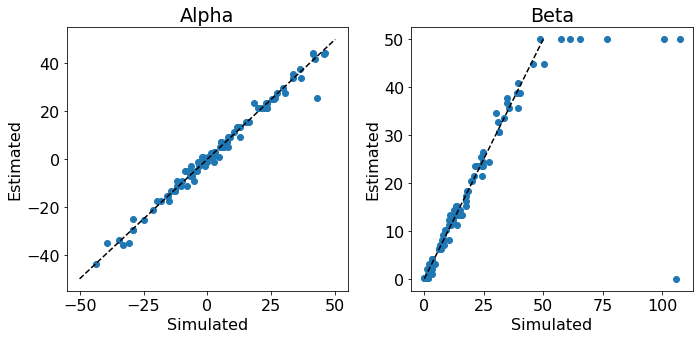

In [49]:
#Test to see the fits - single simulation 
Ntrials = 50 #trials per stimulus level
Nsims = 100 #number of times to simulate

#Feed in stimuli 
X = np.arange(-100,110,10)
a_range = np.linspace(-100,100)
b_range = np.linspace(0.001,100)
    
alpha_est = []
beta_est = []
all_alphas = []
all_betas = []
for n in range(Nsims):

    alpha_sim = norm.rvs(0,20)
    beta_sim = expon.rvs(0,20)
    all_alphas = np.append(all_alphas, alpha_sim)
    all_betas = np.append(all_betas, beta_sim)
    
    #Set the priors
    p_alpha = norm.pdf(a_range,0,20)
    p_alpha = np.reshape(p_alpha,(len(p_alpha),1))
    p_beta = expon.pdf(b_range,0,20)
    p_beta = np.reshape(p_beta,(len(p_beta),1))
    Prior = p_alpha @ p_beta.T
    Prior = Prior/np.nansum(np.nansum(Prior))

    #Randomize stimuli
    All_stims = []
    for t in range(Ntrials):
        All_stims = np.append(All_stims,np.random.permutation(X))

    #Loop through all trials
    stims = []
    responses = []
    alpha_EV = []
    beta_EV = []
    Posterior = []
    for i in range(len(All_stims)):

        stims = np.append(stims,All_stims[i])

        #Simulate participant
        p_left = norm.cdf(All_stims[i],alpha_sim,beta_sim)
        responses = np.append(responses, p_left > np.random.rand())

        #Account for repeated stimuli 
        Unique_stims, stim_idx = np.unique(stims, return_index=True)
        Unique_stims = stims[np.sort(stim_idx)]
        Nstims = []
        Kleft = []
        for u in Unique_stims:
            stim_idx = np.argwhere(u==stims)[:,0]
            Nstims = np.append(Nstims,len(stim_idx))
            Kleft = np.append(Kleft, np.sum(responses[stim_idx]))

        #Calcualte the likelihood for the response given the current parameters
        Likelihood = np.empty((len(a_range),len(b_range)))
        for a_idx, a in enumerate(a_range):
            for b_idx, b in enumerate(b_range):
                psi = norm.cdf(Unique_stims,a,b)
                Likelihood[a_idx,b_idx] = np.prod((psi**Kleft) * ((1-psi)**(Nstims-Kleft)))

        #Calculate the posterior
        Posterior = Likelihood*Prior
        Posterior = Posterior/np.nansum(np.nansum(Posterior))

        #Marginalize the posterior
        alpha_post = np.nansum(Posterior,axis=1)
        beta_post = np.nansum(Posterior,axis=0)

        #Calculate the expected value of each
        alpha_EV = np.append(alpha_EV, np.nansum(a_range*alpha_post))
        beta_EV = np.append(beta_EV, np.nansum(b_range*beta_post))

        #The posterior becomes the prior for the next trial
        Prior = Posterior 
    
    #Store the estimates
    alpha_est = np.append(alpha_est, alpha_EV[-1])
    beta_est = np.append(beta_est, beta_EV[-1])
    
#Plot the result    
fig, ax = plt.subplots(1,2, figsize=(10,5), tight_layout=True)
ax[0].plot(all_alphas,alpha_est,'o')
ax[0].plot(a_range,a_range,'k--')
ax[0].set(xlabel='Simulated',ylabel='Estimated',title='Alpha',ylim=(-100,100),xlim=(-100,100))
ax[1].plot(all_betas,beta_est,'o')
ax[1].plot(b_range,b_range,'k--')
ax[1].set(xlabel='Simulated',ylabel='Estimated',title='Beta',ylim=(-100,100),xlim=(-100,100))
plt.show()

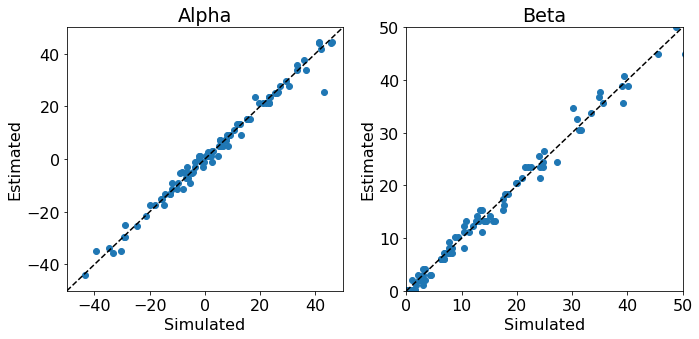

In [52]:
#Plot the result    
fig, ax = plt.subplots(1,2, figsize=(10,5), tight_layout=True)
ax[0].plot(all_alphas,alpha_est,'o')
ax[0].plot(a_range,a_range,'k--')
ax[0].set(xlabel='Simulated',ylabel='Estimated',title='Alpha',ylim=(-50,50),xlim=(-50,50))
ax[1].plot(all_betas,beta_est,'o')
ax[1].plot(b_range,b_range,'k--')
ax[1].set(xlabel='Simulated',ylabel='Estimated',title='Beta',ylim=(0,50),xlim=(0,50))
plt.show()

This looks like it is working nicely. The simulated and estimated values fall very close to the unity line. It looks off in the top plot but the range of beta values cannot go past 50. So we can adjust this next time

***

#### How does the posterior evolve over the initial phases of the algorithm?
The authors say that initially the algorithm homes in on the estimates of $\alpha$. Intuitively, this is probably because you gain the most information from knowing the $\alpha$ estimate initially. We also need to know where the threshold is to estimtae $\beta$, which is above and below the threshold value.

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


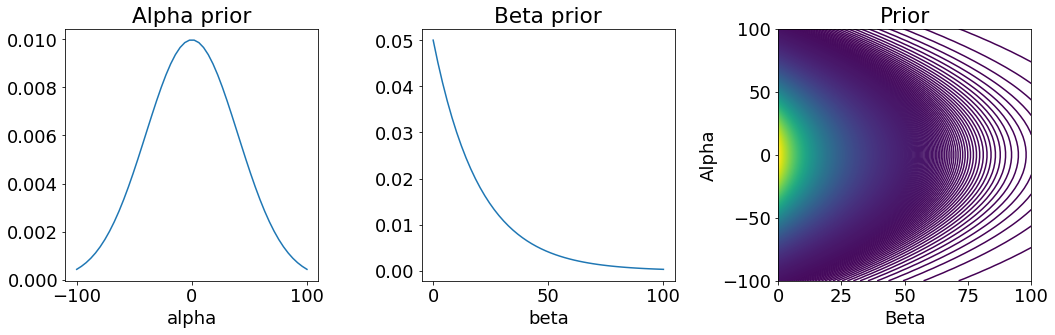

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log2
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in multiply
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log2
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in multiply


Trial #: 1
Simulus position =  0.0
Response =  0.0


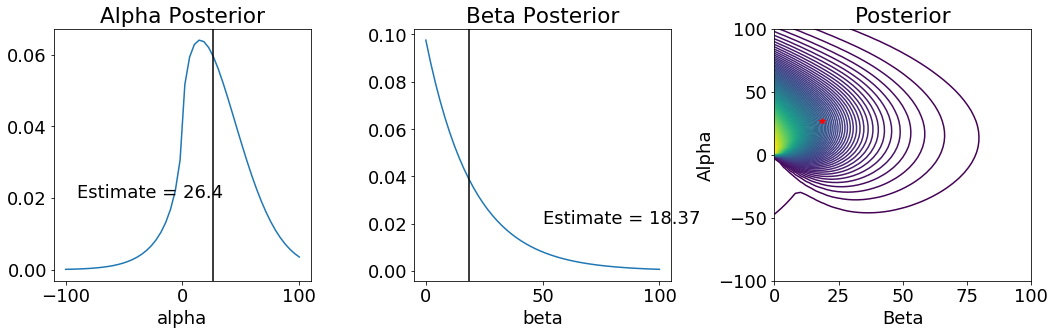

Trial #: 2
Simulus position =  30.0
Response =  0.0


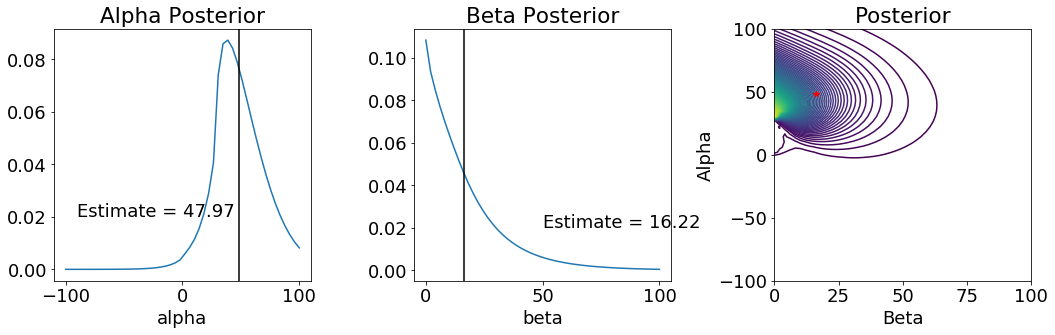

Trial #: 3
Simulus position =  50.0
Response =  1.0


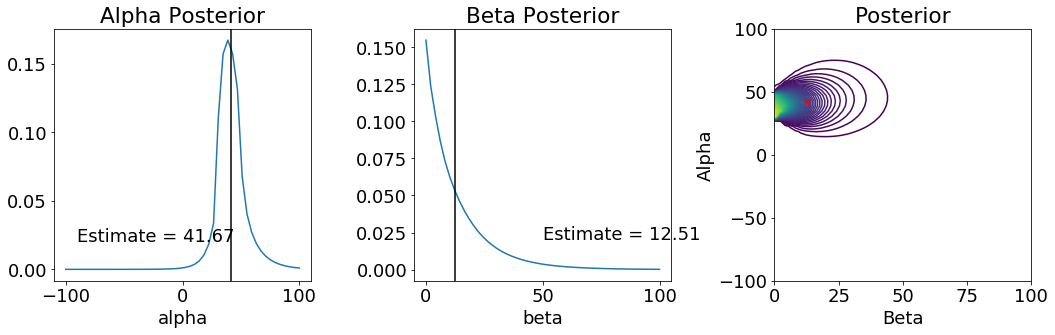

Trial #: 4
Simulus position =  40.0
Response =  1.0


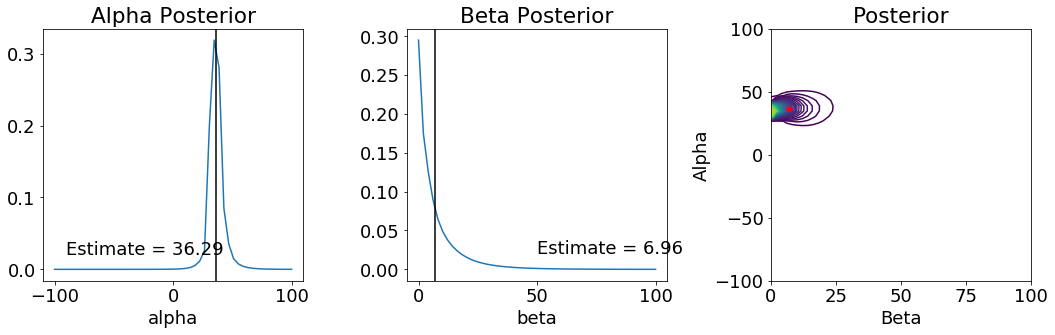

Trial #: 5
Simulus position =  40.0
Response =  1.0


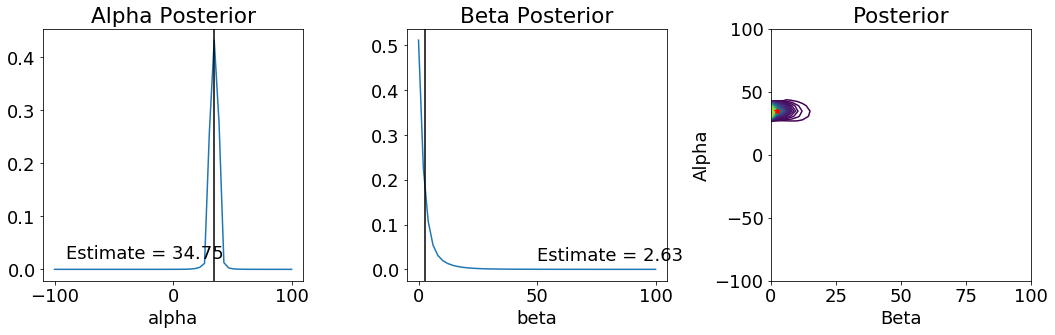

Trial #: 10
Simulus position =  20.0
Response =  0.0


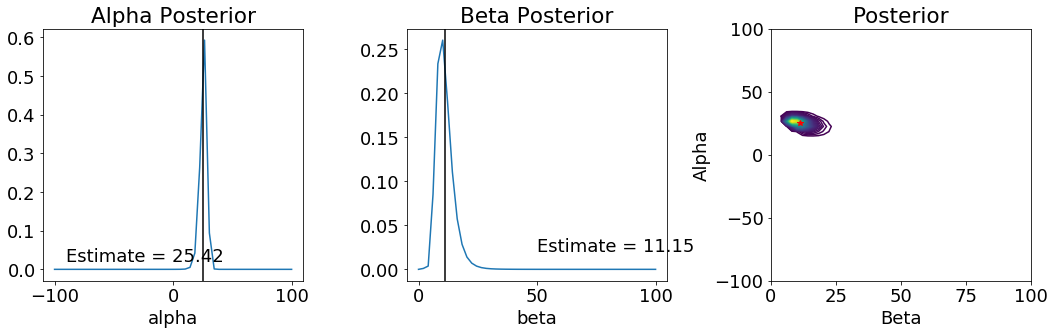

Trial #: 20
Simulus position =  -10.0
Response =  0.0


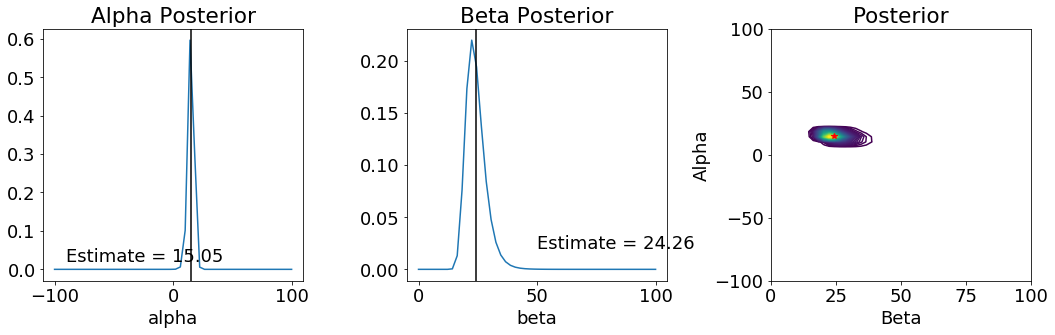

Trial #: 30
Simulus position =  -40.0
Response =  0.0


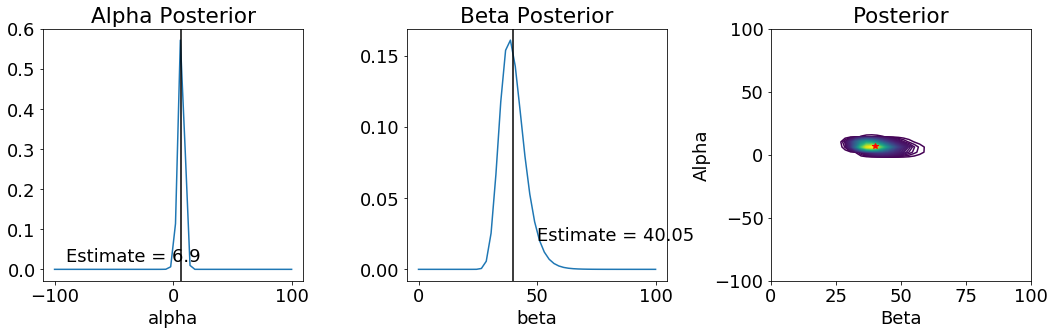

Trial #: 40
Simulus position =  -50.0
Response =  0.0


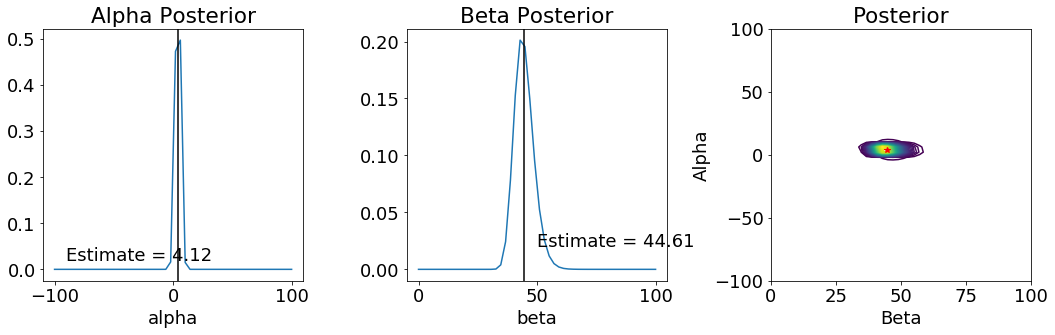

Trial #: 50
Simulus position =  50.0
Response =  1.0


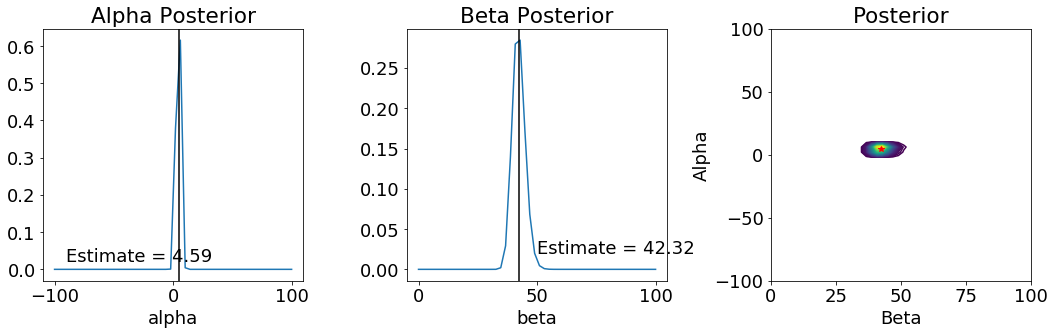

In [102]:
#Set some values for the expeirment
Ntrials = 50
#Set the parameters
alpha = 10
beta = 50
gam = 0.02
lam = 0.02

#Create the lookup tables
X = np.arange(-100,110,10)
a_range = np.linspace(-100,100)
b_range = np.linspace(0.001,100)
p_left_look, p_right_look = Psi_lookT(X,a_range,b_range)

#Set the priors
p_alpha = norm.pdf(a_range,0,40)
p_beta = expon.pdf(b_range,0,20)
p_alpha = np.reshape(p_alpha,(len(p_alpha),1))
p_beta = np.reshape(p_beta,(len(p_beta),1))

#Create the 2d prior and make sure it sums to 1
Prior = p_alpha @ p_beta.T
Prior = Prior/np.nansum(np.nansum(Prior))

#Plot the prior
fig, ax = plt.subplots(1,3,figsize=(15,5),tight_layout=True)
ax[0].plot(a_range,p_alpha)
ax[0].set(title='Alpha prior',xlabel='alpha')
ax[1].plot(b_range,p_beta)
ax[1].set(title='Beta prior',xlabel='beta')
ax[2].contour(b_range,a_range,Prior,1000)
ax[2].set(title='Prior',xlabel='Beta',ylabel='Alpha')
plt.show()

#Stimulate
alpha_EV, beta_EV, stims, responses, Posterior = PSIsim(
    Ntrials, params, X, a_range, b_range, Prior, p_left_look, p_right_look)
  
#initialize 
stims = []
responses = []
alpha_EV = []
beta_EV = []
#Start the experiment
for t in range(Ntrials):

    #First simulate through each possible stim value, X, and calculate entropy
    _, best_X = CalcH(X, p_left_look, p_right_look, Prior)
    stims = np.append(stims, best_X)

    #Participant makes a selection
    P_left = gam + (1 - lam - gam)*norm.cdf(stims[t],alpha,beta)
    responses = np.append(responses, P_left > np.random.rand())

    #Account for repeated stimuli 
    Unique_stims, stim_idx = np.unique(stims, return_index=True)
    Unique_stims = stims[np.sort(stim_idx)]
    Nstims = []
    Kleft = []
    for u in Unique_stims:
        stim_idx = np.argwhere(u==stims)[:,0]
        Nstims = np.append(Nstims,len(stim_idx))
        Kleft = np.append(Kleft, np.sum(responses[stim_idx]))

    #Calcualte the likelihood for the response given the current parameters
    Likelihood = np.empty((len(a_range),len(b_range)))
    for a_idx, a in enumerate(a_range):
        for b_idx, b in enumerate(b_range):
            psi = gam + (1 - lam - gam)*norm.cdf(Unique_stims,a,b)
            Likelihood[a_idx,b_idx] = np.prod((psi**Kleft) * ((1-psi)**(Nstims-Kleft)))

    #Calculate the posterior
    Posterior = Likelihood*Prior
    Posterior = Posterior/np.nansum(np.nansum(Posterior))
    
    #Marginalize the posterior
    alpha_post = np.nansum(Posterior,axis=1)
    beta_post = np.nansum(Posterior,axis=0)

    #Calculate the expected value of each
    alpha_EV = np.append(alpha_EV, np.nansum(a_range*alpha_post))
    beta_EV = np.append(beta_EV, np.nansum(b_range*beta_post))
    
    if t <5 or np.remainder(t+1, 10)==0:
        print('Trial #:', t+1)
        print('Simulus position = ', stims[t])
        print('Response = ', responses[t])

        #Plot
        fig, ax = plt.subplots(1,3,figsize=(15,5),tight_layout=True)
        ax[0].plot(a_range,alpha_post)
        ax[0].axvline(x=alpha_EV[t],color='k')
        ax[0].text(-90, 0.02, 'Estimate = ' + str(round(alpha_EV[t],2)))
        ax[0].set(title='Alpha Posterior',xlabel='alpha')
        ax[1].plot(b_range,beta_post)
        ax[1].axvline(x=beta_EV[t],color='k')    
        ax[1].text(50, 0.02, 'Estimate = ' + str(round(beta_EV[t],2)))
        ax[1].set(title='Beta Posterior',xlabel='beta')
        ax[2].contour(b_range,a_range,Posterior,100)
        ax[2].plot(beta_EV[t],alpha_EV[t],'r*')
        ax[2].set(title='Posterior',xlabel='Beta',ylabel='Alpha')
        plt.show()
    
    #The posterior becomes the prior for the next trial
    Prior = Posterior

Notice how small the alpha estimate gets in just the first 5 trials. The beta estimate is also getting smaller but then the spread is relatively larger on the alpha axis in the posterior compared to the beta estimate. 

Skipping ahead to trial 10, the beta estimate is much smaller than previously. The esimates stay really small from then on out. Notice that this is for a small beta value ($\beta$ = 5). Next, I tried simulating with a larger $\beta$ values like 10. Here, both estimates shift after the first 5 trials, but they dont shift as much because they have already been established as pretty solid. 

Last, I tired an extreme value of beta (50). Both estimates still get smaller at the point of trial 5. Then the estimates start getting wider especially along the beta estimate. It actualy does a pretty good job of estimating both values. 

## Define functions

The main functions are the lookup table, the entropy function and we put them all together in the psi simulation function

In [2]:
#Look up table
def Psi_lookT(X,a_range,b_range):
    """
    This function creates two lookup tables required for the psi algorithm to run more efficiently
    It is a table of probabilities for both responses (left and right in this case) given all possible
    alpha and beta values and all possible stimulus locations:
    p(r='left'|alpha,beta,X)
    p(r='right'|alpha,beta,X)
    """
    #Set these nuisance parameters to nonzero values
    gam = 0.02
    lam = 0.02
    
    #Preallocate the lookup tables
    p_left_look = np.empty([len(b_range),len(a_range),(len(X))])
    p_right_look = np.empty([len(b_range),len(a_range),(len(X))])
    
    #Loop through all possible stimulus, alpha and beta values
    for x_i, x in enumerate(X):
        for a_i, a in enumerate(a_range):
            for b_i, b in enumerate(b_range):
                psi = gam + (1 - lam - gam) * norm.cdf(x,a,b)
                p_left_look[a_i,b_i,x_i] = psi
                p_right_look[a_i,b_i,x_i] = 1-psi

    return p_left_look, p_right_look

In [3]:
#Entropy
def CalcH(X, p_left_look, p_right_look, Prior):

    """
    This function calculates the entropy (H) of each possible stimulus value to determine which one minimizes,
    the entropy for the next trial. This is the stimulus that will provide the most information for both parameters
    """
    
    #Simulate through each possible stim value, X
    EH = []
    for i, x in enumerate(X):

        #Calculate the probability of getting a response, r, after presenting test x at the next trial (across all possible parameter values)
        p_left = np.nansum(np.nansum(np.multiply(p_left_look[:,:,i],Prior)))
        p_right = np.nansum(np.nansum(np.multiply(p_right_look[:,:,i],Prior)))

        #Calculate the posterior for each response 
        Post_left = np.multiply(Prior,p_left_look[:,:,i])
        Post_left = np.divide(Post_left, np.nansum(np.nansum(Post_left)))
        Post_right = np.multiply(Prior,p_right_look[:,:,i])
        Post_right = np.divide(Post_right, np.nansum(np.nansum(Post_right)))

        #Estimate the entropy of the posterior distribution for each response
        H_left = -np.nansum(np.nansum(np.multiply(Post_left, np.log2(Post_left))))
        H_right = -np.nansum(np.nansum(np.multiply(Post_right, np.log2(Post_right))))
        
        #Combine the entropy calculations, weighted by their probabilities
        Total_H = (H_left*p_left) + (H_right*p_right)
        EH = np.append(EH, Total_H)
        
    best_X = X[np.argmin(EH)]
    return EH, best_X

In [4]:
#PSI simulation 
def PSIsim(Ntrials, params, X, a_range, b_range, Prior, p_left_look, p_right_look):
    
    """
    Simulate the Psi algorithm with the number of trials and the given parameters (params),
    Need to also input the range of possible alpha and beta values, the prior and the lookup tables
    """

    #Define the parameters
    alpha = params[0]
    beta = params[1]
    lam = params[2]
    gam = params[3]
    
    #initialize 
    stims = []
    responses = []
    alpha_EV = []
    beta_EV = []
    
    #Start the experiment
    for t in range(Ntrials):
        
        #First simulate through each possible stim value, X, and calculate entropy
        _, best_X = CalcH(X, p_left_look, p_right_look, Prior)
        stims = np.append(stims, best_X)

        #Participant makes a selection
        P_left = gam + (1 - lam - gam)*norm.cdf(stims[t],alpha,beta)
        responses = np.append(responses, P_left > np.random.rand())
        
        #Account for repeated stimuli 
        Unique_stims, stim_idx = np.unique(stims, return_index=True)
        Unique_stims = stims[np.sort(stim_idx)]
        Nstims = []
        Kleft = []
        for u in Unique_stims:
            stim_idx = np.argwhere(u==stims)[:,0]
            Nstims = np.append(Nstims,len(stim_idx))
            Kleft = np.append(Kleft, np.sum(responses[stim_idx]))

        #Calcualte the likelihood for the response given the current parameters
        Likelihood = np.empty((len(a_range),len(b_range)))
        for a_idx, a in enumerate(a_range):
            for b_idx, b in enumerate(b_range):
                psi = gam + (1 - lam - gam)*norm.cdf(Unique_stims,a,b)
                Likelihood[a_idx,b_idx] = np.prod((psi**Kleft) * ((1-psi)**(Nstims-Kleft)))
        
        #Calculate the posterior
        Posterior = Likelihood*Prior
        Posterior = Posterior/np.nansum(np.nansum(Posterior))
        
        #Marginalize the posterior
        alpha_post = np.nansum(Posterior,axis=1)
        beta_post = np.nansum(Posterior,axis=0)
        
        #Calculate the expected value of each
        alpha_EV = np.append(alpha_EV, np.nansum(a_range*alpha_post))
        beta_EV = np.append(beta_EV, np.nansum(b_range*beta_post))
        
        #The posterior becomes the prior for the next trial
        Prior = Posterior
        
    return alpha_EV, beta_EV, stims, responses, Posterior

## Simulate

### Single participant simulation

**Prior justification:** We need to create a 2d prior made up of $\alpha$ and $\beta$ probabilities

**Alpha:** The maximum entropy distirbution for alpha is a Gaussian. We should center this on 0 because we have no reason to think there would be a bias prior to testing. The standard deviation should also reflect our possible range of alpha values (-100 to 100). Therefore, we should set it at 40, that way 95% of the distribution lies within -80 and 80. Values outside of that should be very unlikely. 

**Beta:** The maximum entropy distribution for beta is an exponential distribution. We can parameterize this distribution with $\lambda$ which is the decay parameter or event rate. In the python function `expon.pdf` there are two parameters, loc and scale. The loc parameter should be 0 because we do not want to shift the probability distribuiton. The scale parameter is equivilant to $\frac{\displaystyle 1}{\displaystyle \lambda}$ where $\lambda$ is the decay parameter. The full equation is $y = \frac{\displaystyle 1}{\displaystyle \lambda} * \exp^{\frac{\displaystyle -x}{\displaystyle \lambda}}$. In this case, $\lambda$ can be interpreted as the $\beta$ parameter that has ~36% probability relative to the other potential $\beta$ values. That means the value we choose for $\lambda$ should be one which we think is towards the edge of being unlikely to show up in our sample. Based on our pilot data, 20 is a good value for this. 

**Create look up tables and priors:**

Sum of prior =  1.0


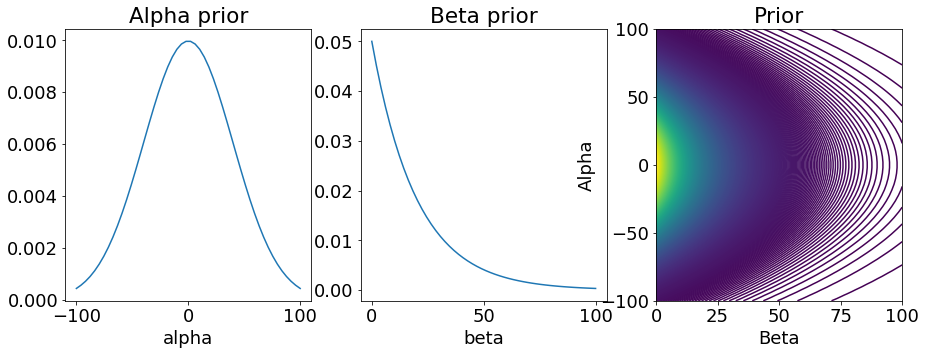

In [78]:
#Create the lookup tables
X = np.arange(-100,110,10)
a_range = np.linspace(-100,100)
b_range = np.linspace(0.001,100)
p_left_look, p_right_look = Psi_lookT(X,a_range,b_range)

#Set the priors
p_alpha = norm.pdf(a_range,0,40)
p_beta = expon.pdf(b_range,0,20)
p_alpha = np.reshape(p_alpha,(len(p_alpha),1))
p_beta = np.reshape(p_beta,(len(p_beta),1))

#Create the 2d prior and make sure it sums to 1
Prior = p_alpha @ p_beta.T
Prior = Prior/np.nansum(np.nansum(Prior))

print('Sum of prior = ', round(sum(sum(Prior))))

#Plot
fig, ax = plt.subplots(1,3,figsize=(15,5),tight_layout=False)
ax[0].plot(a_range,p_alpha)
ax[0].set(title='Alpha prior',xlabel='alpha')
ax[1].plot(b_range,p_beta)
ax[1].set(title='Beta prior',xlabel='beta')
ax[2].contour(b_range,a_range,Prior,1000)
ax[2].set(title='Prior',xlabel='Beta',ylabel='Alpha')
plt.show()

**Simulate the experiment**

In [83]:
#Set some values for the expeirment
Ntrials = 50
#Set the parameters
alpha_sim = norm.rvs(0,20)
beta_sim = expon.rvs(0,20)
params = [alpha_sim,
          beta_sim, 
          0.02, 
          0.02]

#Stimulate
alpha_EV, beta_EV, stims, responses, Posterior = PSIsim(
    Ntrials, params, X, a_range, b_range, Prior, p_left_look, p_right_look)

print('Alpha:')
print('Simulated = ' + str(round(alpha_sim,2)))
print('Estimated = ' + str(round(alpha_EV[-1],2)))
print('')
print('Beta:')
print('Simulated = ' + str(round(beta_sim,2)))
print('Estimated = ' + str(round(beta_EV[-1],2)))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log2
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in multiply
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log2
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in multiply


Alpha:
Simulated = -38.04
Estimated = -23.44

Beta:
Simulated = 50.78
Estimated = 48.5


**Plot the stimulation**

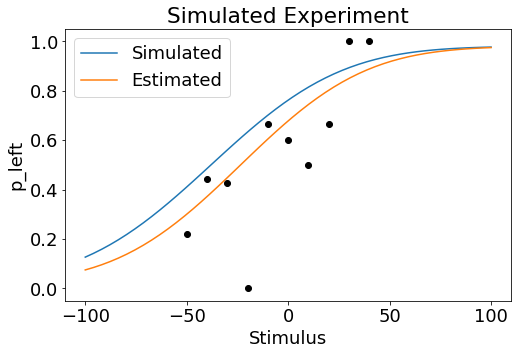

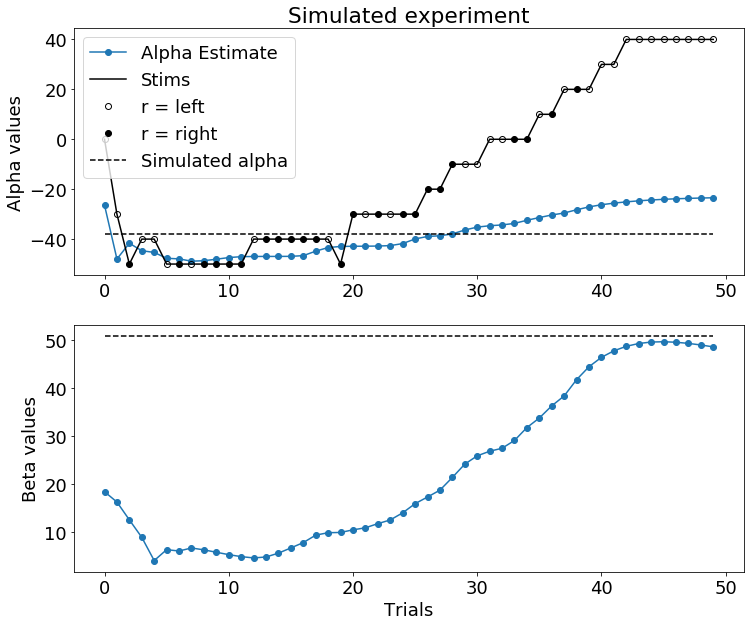

In [84]:
#Set up the plot 
psi_sim = 0.02 + (1 - 0.02 - 0.02)*norm.cdf(a_range,alpha_sim,beta_sim)
psi_est = 0.02 + (1 - 0.02 - 0.02)*norm.cdf(a_range,alpha_EV[-1],beta_EV[-1])

#Account for repeated stimuli 
Unique_stims, stim_idx = np.unique(stims, return_index=True)
Unique_stims = stims[np.sort(stim_idx)]
Nstims = []
Kleft = []
for u in Unique_stims:
    stim_idx = np.argwhere(u==stims)[:,0]
    Nstims = np.append(Nstims,len(stim_idx))
    Kleft = np.append(Kleft, np.sum(responses[stim_idx]))

#Plot the psychometric function
fig, ax = plt.subplots(1,figsize=(8,5))
ax.plot(a_range,psi_sim,label='Simulated')
ax.plot(a_range,psi_est,label='Estimated')
ax.plot(Unique_stims,(Kleft/Nstims),'ko')
ax.set(xlabel='Stimulus',ylabel='p_left',title='Simulated Experiment')
ax.legend()
plt.show()

#Plot the experiment trial by trial
fig, ax = plt.subplots(2,1,figsize=(12,10),tight_layout=False)
ax[0].plot(alpha_EV,'o-',label='Alpha Estimate')
ax[0].plot(stims,'k-',label='Stims')
ax[0].plot(np.argwhere(responses==1),stims[responses==1],'ko-',label='r = left',fillstyle='none',linestyle='none')
ax[0].plot(np.argwhere(responses==0),stims[responses==0],'ko-',label='r = right',linestyle='none')
ax[0].plot(np.ones(len(alpha_EV))*alpha_sim,'k--',label='Simulated alpha')
ax[0].legend()
ax[0].set(title='Simulated experiment',ylabel='Alpha values')
ax[1].plot(beta_EV,'o-',label='Beta Estimate')
ax[1].plot(np.ones(len(beta_EV))*beta_sim,'k--',label='Simulated beta')
ax[1].set(ylabel='Beta values',xlabel='Trials')
plt.show()

### How does the number of trials impact the estimates?

Greater number of trials should help the estimates of $\alpha$ and $\beta$. This is a trade off, we want the test to be efficient but also reliable and able to recover the parameters consistently. The next block of code simulates to determine which number of trials (within reason) become most reliable. (Warning: This takes a long time to run!!).

Testing 10 trials
Alpha CCC =  0.84
Beta CCC =  0.1


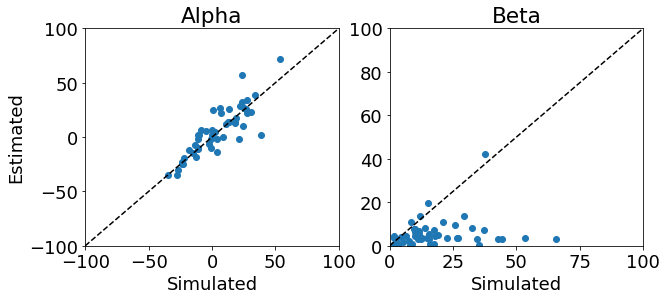

Testing 25 trials


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log2
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in multiply
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log2
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in multiply


Alpha CCC =  0.92
Beta CCC =  0.26


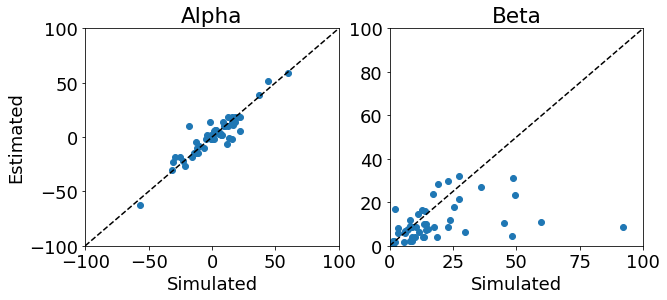

Testing 50 trials
Alpha CCC =  0.88
Beta CCC =  0.82


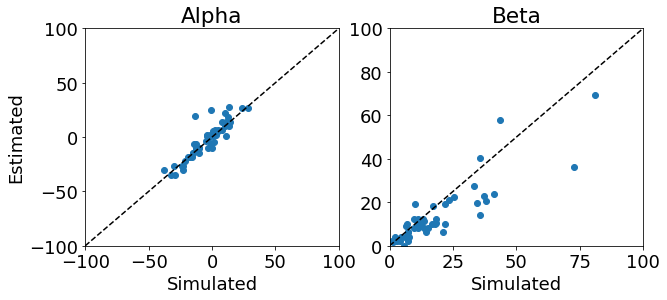

Testing 75 trials
Alpha CCC =  0.95
Beta CCC =  0.71


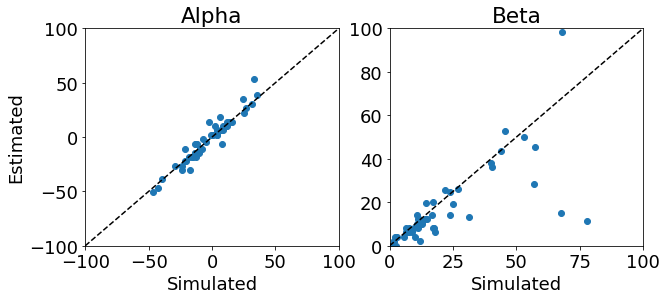

Testing 100 trials


KeyboardInterrupt: 

In [104]:
#Set some values for the expeirment
Ntrials = [10, 25, 50, 75, 100, 150]
Nsubjs = 50

#Create the lookup tables
X = np.arange(-100,110,10)
a_range = np.linspace(-100,100)
b_range = np.linspace(0.001,100)
p_left_look, p_right_look = Psi_lookT(X,a_range,b_range)

CCC_alpha = []
CCC_beta = []
for i, n in enumerate(Ntrials):
    print('Testing', n, 'trials')
    Sim_alphas = []
    Sim_betas = []
    Est_alphas = []
    Est_betas = []
    for s in range(Nsubjs):
        
        #Set the priors
        p_alpha = norm.pdf(a_range,0,40)
        p_beta = expon.pdf(b_range,0,20)
        p_alpha = np.reshape(p_alpha,(len(p_alpha),1))
        p_beta = np.reshape(p_beta,(len(p_beta),1))
        Prior = p_alpha @ p_beta.T
        Prior = Prior/np.nansum(np.nansum(Prior))

        #Set the parameters
        alpha_sim = norm.rvs(0,20)
        beta_sim = expon.rvs(0,20)
        params = [alpha_sim, beta_sim, 0.02, 0.02]
        
        Sim_alphas = np.append(Sim_alphas, alpha_sim)
        Sim_betas = np.append(Sim_betas, beta_sim)
    
        #Stimulate
        alpha_EV, beta_EV, _, _, _ = PSIsim(n, params, X, a_range, b_range, Prior, p_left_look, p_right_look)
        
        Est_alphas = np.append(Est_alphas, alpha_EV[-1])
        Est_betas = np.append(Est_betas, beta_EV[-1])

    #Calculate ccc
    r_alpha, _ = stats.pearsonr(Sim_alphas,Est_alphas)
    r_beta, _ = stats.pearsonr(Sim_betas,Est_betas)
    CCC_alpha = np.append(CCC_alpha, 
                          (2*r_alpha*np.std(Sim_alphas)*np.std(Est_alphas)) / ((np.mean(Sim_alphas) - np.mean(Est_alphas))**2 + (np.var(Sim_alphas) + np.var(Est_alphas))))
    CCC_beta = np.append(CCC_beta,
                         (2*r_beta*np.std(Sim_betas)*np.std(Est_betas)) / ((np.mean(Sim_betas) - np.mean(Est_betas))**2 + (np.var(Sim_betas) + np.var(Est_betas))))
    
    print('Alpha CCC = ', str(round(CCC_alpha[i],2)))
    print('Beta CCC = ', str(round(CCC_beta[i],2)))

    #Plot
    fig, ax = plt.subplots(1,2,figsize=(10,4), tight_layout=False)
    ax[0].plot(Sim_alphas,Est_alphas,'o')
    ax[0].plot(a_range,a_range,'k--')
    ax[0].set(xlim=(-100, 100),ylim=(-100,100),xlabel='Simulated',ylabel='Estimated',title='Alpha')
    ax[1].plot(Sim_betas,Est_betas,'o')
    ax[1].plot(b_range,b_range,'k--')
    ax[1].set(xlim=(0, 100), ylim=(0,100),xlabel='Simulated',title='Beta')
    plt.show()
    
fig, ax = plt.subplots(1, figsize=(10,5))
ax.plot(Ntrials,CCC_alpha,'o-',label='Alpha')
ax.plot(Ntrials,CCC_beta,'o-',label='beta')
ax.plot(Ntrials,np.ones(len(Ntrials))*0.9,'k--')
ax.set(ylim=(0,1),ylabel='CCC',xlabel='Ntrials',title='Parameter Recovery')
plt.legend()
plt.show()    

### Do continuous or discrete stimulus values work better for estimates?
Concievibly, we could stimulate at every millimeter. But are millimeters too close together for any human to detect differences between foot position? 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log2
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in multiply
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log2
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in multiply


Alpha Discrete CCC =  0.98
Alpha Continuous CCC =  0.97
Beta Discrete CCC =  0.7
Beta Continuous CCC =  0.79


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


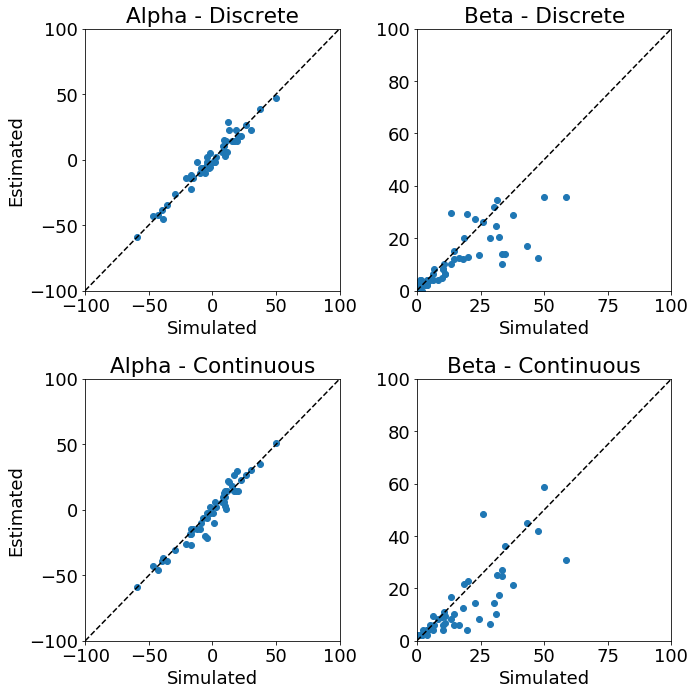

In [103]:
#Set some values for the expeirment
Ntrials = 50
Nsubjs = 50

a_range = np.linspace(-100,100)
b_range = np.linspace(0.001,100)

#Create the lookup tables
X_dis = np.arange(-100,110,10)
X_con = np.arange(-100,101,1)
p_left_look_Dis, p_right_look_Dis = Psi_lookT(X_dis,a_range,b_range)
p_left_look_Con, p_right_look_Con = Psi_lookT(X_con,a_range,b_range)

Sim_alphas = []
Sim_betas = []
Est_alphas_Dis = []
Est_alphas_Con = []
Est_betas_Dis = []
Est_betas_Con = []
for s in range(Nsubjs):

    #Set the priors
    p_alpha = norm.pdf(a_range,0,40)
    p_beta = expon.pdf(b_range,0,20)
    p_alpha = np.reshape(p_alpha,(len(p_alpha),1))
    p_beta = np.reshape(p_beta,(len(p_beta),1))
    Prior = p_alpha @ p_beta.T
    Prior = Prior/np.nansum(np.nansum(Prior))

    #Set the parameters
    alpha_sim = norm.rvs(0,20)
    beta_sim = expon.rvs(0,20)
    params = [alpha_sim, beta_sim, 0.02, 0.02]
    Sim_alphas = np.append(Sim_alphas, alpha_sim)
    Sim_betas = np.append(Sim_betas, beta_sim)

    #Stimulate
    alpha_EV_Dis, beta_EV_Dis, _, _, _ = PSIsim(Ntrials, params, X_dis, a_range, b_range, Prior, p_left_look_Dis, p_right_look_Dis)
    alpha_EV_Con, beta_EV_Con, _, _, _ = PSIsim(Ntrials, params, X_con, a_range, b_range, Prior, p_left_look_Con, p_right_look_Con)

    #Save the estimated parameters
    Est_alphas_Dis = np.append(Est_alphas_Dis, alpha_EV_Dis[-1])
    Est_alphas_Con = np.append(Est_alphas_Con, alpha_EV_Con[-1])
    Est_betas_Dis = np.append(Est_betas_Dis, beta_EV_Dis[-1])
    Est_betas_Con = np.append(Est_betas_Con, beta_EV_Con[-1])

#Calculate ccc
r_alpha_Dis, _ = stats.pearsonr(Sim_alphas,Est_alphas_Dis)
r_alpha_Con, _ = stats.pearsonr(Sim_alphas,Est_alphas_Con)
r_beta_Dis, _ = stats.pearsonr(Sim_betas,Est_betas_Dis)
r_beta_Con, _ = stats.pearsonr(Sim_betas,Est_betas_Con)

CCC_alpha_Dis = (2*r_alpha_Dis*np.std(Sim_alphas)*np.std(Est_alphas_Dis)) / ((np.mean(Sim_alphas) - np.mean(Est_alphas_Dis))**2 + (np.var(Sim_alphas) + np.var(Est_alphas_Dis)))
CCC_alpha_Con = (2*r_alpha_Con*np.std(Sim_alphas)*np.std(Est_alphas_Con)) / ((np.mean(Sim_alphas) - np.mean(Est_alphas_Con))**2 + (np.var(Sim_alphas) + np.var(Est_alphas_Con)))
CCC_beta_Dis = (2*r_beta_Dis*np.std(Sim_betas)*np.std(Est_betas_Dis)) / ((np.mean(Sim_betas) - np.mean(Est_betas_Dis))**2 + (np.var(Sim_betas) + np.var(Est_betas_Dis)))
CCC_beta_Con = (2*r_beta_Con*np.std(Sim_betas)*np.std(Est_betas_Con)) / ((np.mean(Sim_betas) - np.mean(Est_betas_Con))**2 + (np.var(Sim_betas) + np.var(Est_betas_Con)))

print('Alpha Discrete CCC = ', str(round(CCC_alpha_Dis,2)))
print('Alpha Continuous CCC = ', str(round(CCC_alpha_Con,2)))
print('Beta Discrete CCC = ', str(round(CCC_beta_Dis,2)))
print('Beta Continuous CCC = ', str(round(CCC_beta_Con,2)))

#Plot
fig, ax = plt.subplots(2,2,figsize=(10,10), tight_layout=True)
ax[0,0].plot(Sim_alphas,Est_alphas_Dis,'o')
ax[0,0].plot(a_range,a_range,'k--')
ax[0,0].set(xlim=(-100, 100),ylim=(-100,100),xlabel='Simulated',ylabel='Estimated',title='Alpha - Discrete')

ax[0,1].plot(Sim_betas,Est_betas_Dis,'o')
ax[0,1].plot(b_range,b_range,'k--')
ax[0,1].set(xlim=(0, 100), ylim=(0,100),xlabel='Simulated',title='Beta - Discrete')

ax[1,0].plot(Sim_alphas,Est_alphas_Con,'o')
ax[1,0].plot(a_range,a_range,'k--')
ax[1,0].set(xlim=(-100, 100),ylim=(-100,100),xlabel='Simulated',ylabel='Estimated',title='Alpha - Continuous')

ax[1,1].plot(Sim_betas,Est_betas_Con,'o')
ax[1,1].plot(b_range,b_range,'k--')
ax[1,1].set(xlim=(0, 100), ylim=(0,100),xlabel='Simulated',title='Beta - Continuous')
plt.show()

### Does a random extreme stimulus help the estimates? 
Placing stimuli at the extremes of stimulus ranges can help participants feel more engaged in the task as these trials would provide some reprieve from stimuli very close to their threshold. These extreme stimulus placements can also be used to find estimates for the lapse rate, but we will not be using it for this purpose. In the next code block. I want to compare between random stimli placed at extreme values and stimuli placed just at the most efficient value calculated by the entropy and see which one is better.

In [ ]:
#First create a new function for the random stimuli
#PSI simulation 
def PSIsim_Rand(Ntrials, params, X, a_range, b_range, Prior, p_left_look, p_right_look):
    
    """
    Simulate the Psi algorithm with the number of trials and the given parameters (params),
    Need to also input the range of possible alpha and beta values, the prior and the lookup tables
    """

    #Define the parameters
    alpha = params[0]
    beta = params[1]
    lam = params[2]
    gam = params[3]
    
    #initialize 
    stims = []
    responses = []
    alpha_EV = []
    beta_EV = []
    
    #Start the experiment
    for t in range(Ntrials):
        
        #First simulate through each possible stim value, X, and calculate entropy
        if np.remainder(t,10)==0:
            
        else:
            _, best_X = CalcH(X, p_left_look, p_right_look, Prior)
            stims = np.append(stims, best_X)
        
        #Participant makes a selection
        P_left = gam + (1 - lam - gam)*norm.cdf(stims[t],alpha,beta)
        responses = np.append(responses, P_left > np.random.rand())
        
        #Account for repeated stimuli 
        Unique_stims, stim_idx = np.unique(stims, return_index=True)
        Unique_stims = stims[np.sort(stim_idx)]
        Nstims = []
        Kleft = []
        for u in Unique_stims:
            stim_idx = np.argwhere(u==stims)[:,0]
            Nstims = np.append(Nstims,len(stim_idx))
            Kleft = np.append(Kleft, np.sum(responses[stim_idx]))

        #Calcualte the likelihood for the response given the current parameters
        Likelihood = np.empty((len(a_range),len(b_range)))
        for a_idx, a in enumerate(a_range):
            for b_idx, b in enumerate(b_range):
                psi = gam + (1 - lam - gam)*norm.cdf(Unique_stims,a,b)
                Likelihood[a_idx,b_idx] = np.prod((psi**Kleft) * ((1-psi)**(Nstims-Kleft)))
        
        #Calculate the posterior
        Posterior = Likelihood*Prior
        Posterior = Posterior/np.nansum(np.nansum(Posterior))
        
        #Marginalize the posterior
        alpha_post = np.nansum(Posterior,axis=1)
        beta_post = np.nansum(Posterior,axis=0)
        
        #Calculate the expected value of each
        alpha_EV = np.append(alpha_EV, np.nansum(a_range*alpha_post))
        beta_EV = np.append(beta_EV, np.nansum(b_range*beta_post))
        
        #The posterior becomes the prior for the next trial
        Prior = Posterior
        
    return alpha_EV, beta_EV, stims, responses, Posterior

### How do different priors impact the estimates?

### What if we used a logistic function